# Plot CDI

#### Primary Author
Chris Carey

#### Description:
This notebook plots the contact density index (CDI) for clusters and POI categories and exports data for hypothesis testing. 

#### Inputs:
```
data/cbg_attr_and_cluster_1021.csv
exports/home_weekly.csv
exports/poi_health_recategorized.csv
```

#### Ouputs:
```
exports/cdi/cbg_diff_2020.csv
exports/cdi/diff_all.csv
exports/cdi/diff_by_cluster.csv
exports/cdi/total_all.csv
exports/cdi/total_by_cluster.csv
```
 
#### Visualizations:
> Time-series plot of CDI\
> Time-series plot of change in CDI\
> Time-series plot of CDI by cluster\
> Time-series plot of CDI by POI category\

In [55]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz

import warnings
warnings.filterwarnings('ignore')

In [56]:
FONT_SIZE_TICKS=13
FONT_SIZE_AXIS=14
FONT_SIZE_TITLE=16
FONT_SIZE_LEGEND=14
tzinfo = pytz.timezone('US/Eastern')

In [57]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [58]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [59]:
def smoothen(df, columns=[], N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_avg_df = df.copy().reset_index(drop=True)
    # An N-day rolling average with N/2 days before and N/2 after requires N+1
    # days to include the day of as well.
    rolling_avg_df[columns] = (
        rolling_avg_df[columns].rolling(N + 1, center=True).mean())
    return rolling_avg_df

def smoothen_within(df, columns=[], by=None, N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

## Plot CDI

In [60]:
home_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_df)
home_df = home_df[home_df['date_range_start'].dt.year.isin([2019, 2020])]
home_df = home_df.rename(columns={'home_cbg': 'cbg'})
home_df.head()

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
77,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.500000,0.500000,155.884113
78,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050043001,4,6.694275,0.015094,0.015094,5.130999
79,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050051002,4,4.703779,0.005548,0.005548,3.605332
80,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050117001,4,6.766706,0.011429,0.011429,5.186515
81,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050381002,4,8.883041,0.024845,0.024845,6.808635


In [61]:
cdi_total_df = home_df.groupby(by=['date_range_start']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_total_df = cdi_total_df.sort_values(by=['date_range_start'])
cdi_total_df = smoothen(cdi_total_df, columns=['cdi'])
cdi_total_df.to_csv('./exports/cdi/total_all.csv', index=None)
cdi_total_df.head()

,date_range_start,cdi
0,2019-01-07 00:00:00-05:00,NaN
1,2019-01-14 00:00:00-05:00,417256.504886
2,2019-01-21 00:00:00-05:00,301070.216998
3,2019-01-28 00:00:00-05:00,323498.489399
4,2019-02-04 00:00:00-05:00,333907.269703


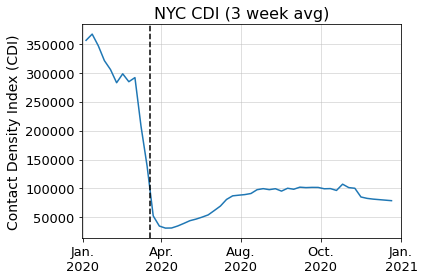

In [82]:
fig, ax = plt.subplots(figsize=(6, 4))
cdi_2020_total_df = cdi_total_df[cdi_total_df['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
ax.plot(cdi_2020_total_df['date_range_start'], cdi_2020_total_df['cdi'])
ax.set_title('NYC CDI (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('Contact Density Index (CDI)', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

plt.tight_layout()
plt.show()

In [63]:
def create_diff_df(cdi_df, diff_columns=[], keep_columns=[]):
    cdi_week_df = cdi_df
    cdi_week_df['year'] = cdi_week_df['date_range_start'].dt.year
    cdi_week_df['week'] = cdi_week_df['date_range_start'].dt.week

    # Dates are missing from December 2020!
    display(cdi_week_df.iloc[95:105])

    cdi_2020_df = cdi_week_df[cdi_week_df['year'] == 2020]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] >= 2]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] <= 52].reset_index(drop=True)
    cdi_2019_df = cdi_week_df[cdi_week_df['year'] == 2019]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] >= 2]
    # Remove dates that can't be compared.
    cdi_2019_df = cdi_2019_df[~cdi_2019_df['week'].isin(set([50, 51]))]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] <= 52].reset_index(drop=True)

    display(cdi_2019_df.head())
    display(cdi_2020_df.head())

    cdi_diff_df = pd.DataFrame()
    for keep_column in (keep_columns + ['week', 'date_range_start']):
        cdi_diff_df[keep_column] = cdi_2020_df[keep_column]
    cdi_diff_df[diff_columns] = (cdi_2020_df[diff_columns] -
                                 cdi_2019_df[diff_columns])
    cdi_diff_df = cdi_diff_df.dropna()

    display(cdi_diff_df.head())

    return cdi_diff_df

In [64]:
cdi_diff_df = create_diff_df(cdi_total_df, diff_columns=['cdi'])
cdi_diff_df.to_csv('./exports/cdi/diff_all.csv', index=None)

,date_range_start,cdi,year,week
95,2020-11-02 00:00:00-05:00,101543.543014,2020,45
96,2020-11-09 00:00:00-05:00,100390.873886,2020,46
97,2020-11-16 00:00:00-05:00,85313.720336,2020,47
98,2020-11-23 00:00:00-05:00,82928.796969,2020,48
99,2020-11-30 00:00:00-05:00,81622.618321,2020,49
100,2020-12-21 00:00:00-05:00,78938.996422,2020,52
101,2020-12-28 00:00:00-05:00,NaN,2020,53


,date_range_start,cdi,year,week
0,2019-01-07 00:00:00-05:00,NaN,2019,2
1,2019-01-14 00:00:00-05:00,417256.504886,2019,3
2,2019-01-21 00:00:00-05:00,301070.216998,2019,4
3,2019-01-28 00:00:00-05:00,323498.489399,2019,5
4,2019-02-04 00:00:00-05:00,333907.269703,2019,6


,date_range_start,cdi,year,week
0,2020-01-06 00:00:00-05:00,356000.705981,2020,2
1,2020-01-13 00:00:00-05:00,366765.133807,2020,3
2,2020-01-20 00:00:00-05:00,346644.476322,2020,4
3,2020-01-27 00:00:00-05:00,320948.025959,2020,5
4,2020-02-03 00:00:00-05:00,305490.215759,2020,6


,week,date_range_start,cdi
1,3,2020-01-13 00:00:00-05:00,-50491.371079
2,4,2020-01-20 00:00:00-05:00,45574.259324
3,5,2020-01-27 00:00:00-05:00,-2550.463440
4,6,2020-02-03 00:00:00-05:00,-28417.053945
5,7,2020-02-10 00:00:00-05:00,-33302.207223


No handles with labels found to put in legend.


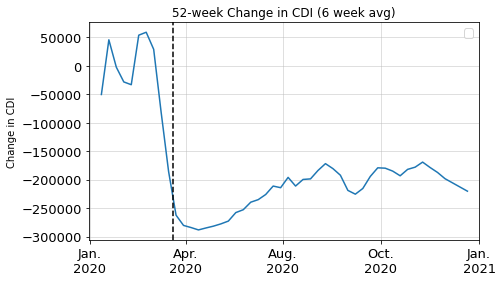

In [65]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(cdi_diff_df['date_range_start'], cdi_diff_df['cdi'])
ax.set_title('52-week Change in CDI (6 week avg)')
ax.set_ylabel('Change in CDI')

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.legend(fontsize=FONT_SIZE_LEGEND-2)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

plt.show()

## Plot CDI by Cluster

In [66]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
})
cbg_df = cbg_df[['cbg', 'cluster', 'population']]
cbg_df.head()

,cbg,cluster,population
0,360050001001,2,6864
1,360050002001,2,1744
2,360050002002,2,1569
3,360050002003,3,1219
4,360050004001,3,598


In [67]:
cluster_df = cbg_df.groupby(by=['cluster']).agg({
    'population': 'sum'
}).reset_index()
cluster_df

,cluster,population
0,0,1523534
1,1,2016402
2,2,2115896
3,3,2763460


In [68]:
merge_df = home_df.merge(cbg_df, how='inner', on=['cbg'])
merge_df.head()

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population
0,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.5,0.5,155.884113,2,6864
1,zzw-225@627-s7t-2ff,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.5,0.5,0.942495,2,6864
2,22b-222@627-s27-fvf,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.2,0.2,3.545440,2,6864
3,zzy-223@627-sb6-g8v,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.2,0.2,0.000000,2,6864
4,225-222@627-s8w-vfz,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.2,0.2,10.950320,2,6864


In [49]:
cdi_cluster_df = merge_df.groupby(by=['date_range_start', 'cluster']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_cluster_df = cdi_cluster_df.merge(cluster_df, how='outer', on=['cluster'])
cdi_cluster_df = cdi_cluster_df.sort_values(by=['date_range_start', 'cluster'])
cdi_cluster_df[
    'cdi_per_capita'] = cdi_cluster_df['cdi'] / cdi_cluster_df['population']
cdi_cluster_df = smoothen_within(cdi_cluster_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='cluster')
cdi_cluster_df.to_csv('./exports/cdi/total_by_cluster.csv', index=None)
cdi_cluster_df.head()

,date_range_start,cluster,cdi,population,cdi_per_capita
0,2019-01-07 00:00:00-05:00,0,NaN,1523534,NaN
0,2019-01-07 00:00:00-05:00,1,NaN,2016402,NaN
0,2019-01-07 00:00:00-05:00,2,NaN,2115896,NaN
0,2019-01-07 00:00:00-05:00,3,NaN,2763460,NaN
1,2019-01-14 00:00:00-05:00,0,87440.256573,1523534,0.057393


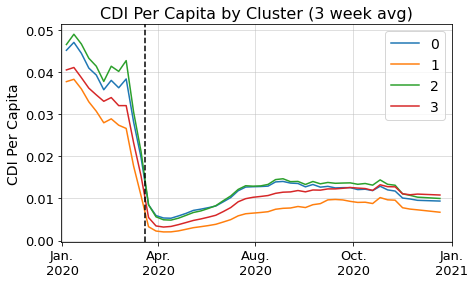

In [50]:
fig, ax = plt.subplots(figsize=(7, 4))
cdi_2020_cluster_df = cdi_cluster_df[cdi_cluster_df['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
for key, group in cdi_2020_cluster_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('CDI Per Capita by Cluster (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('CDI Per Capita', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

ax.legend(fontsize=FONT_SIZE_LEGEND)
plt.show()

In [71]:
cdi_cluster_diff_df = create_diff_df(cdi_cluster_df,
                                     diff_columns=['cdi', 'cdi_per_capita'],
                                     keep_columns=['cluster', 'cdi_per_capita'])
cdi_cluster_diff_df.to_csv('./exports/cdi/diff_by_cluster.csv', index=None)

,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
23,2019-06-17 00:00:00-04:00,3,99412.482007,2763460,0.035974,2019,25
24,2019-06-24 00:00:00-04:00,0,54562.215692,1523534,0.035813,2019,26
24,2019-06-24 00:00:00-04:00,1,71606.817225,2016402,0.035512,2019,26
24,2019-06-24 00:00:00-04:00,2,75183.276610,2115896,0.035533,2019,26
24,2019-06-24 00:00:00-04:00,3,99065.191438,2763460,0.035848,2019,26
25,2019-07-01 00:00:00-04:00,0,54069.224009,1523534,0.035489,2019,27
25,2019-07-01 00:00:00-04:00,1,71806.005983,2016402,0.035611,2019,27
25,2019-07-01 00:00:00-04:00,2,74779.321815,2115896,0.035342,2019,27
25,2019-07-01 00:00:00-04:00,3,98399.649940,2763460,0.035607,2019,27
26,2019-07-08 00:00:00-04:00,0,54064.282856,1523534,0.035486,2019,28


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2019-01-07 00:00:00-05:00,0,NaN,1523534,NaN,2019,2
1,2019-01-07 00:00:00-05:00,1,NaN,2016402,NaN,2019,2
2,2019-01-07 00:00:00-05:00,2,NaN,2115896,NaN,2019,2
3,2019-01-07 00:00:00-05:00,3,NaN,2763460,NaN,2019,2
4,2019-01-14 00:00:00-05:00,0,NaN,1523534,NaN,2019,3


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2020-01-06 00:00:00-05:00,0,62751.078728,1523534,0.041188,2020,2
1,2020-01-06 00:00:00-05:00,1,71233.747454,2016402,0.035327,2020,2
2,2020-01-06 00:00:00-05:00,2,91113.690809,2115896,0.043062,2020,2
3,2020-01-06 00:00:00-05:00,3,108573.873606,2763460,0.039289,2020,2
4,2020-01-13 00:00:00-05:00,0,62718.293167,1523534,0.041166,2020,3


,cluster,cdi_per_capita,week,date_range_start,cdi
12,0,-0.007091,5,2020-01-27 00:00:00-05:00,-10803.645222
13,1,-0.002563,5,2020-01-27 00:00:00-05:00,-5167.573153
14,2,-0.003886,5,2020-01-27 00:00:00-05:00,-8222.175978
15,3,-0.001350,5,2020-01-27 00:00:00-05:00,-3731.635222
16,0,0.000528,6,2020-02-03 00:00:00-05:00,804.365793


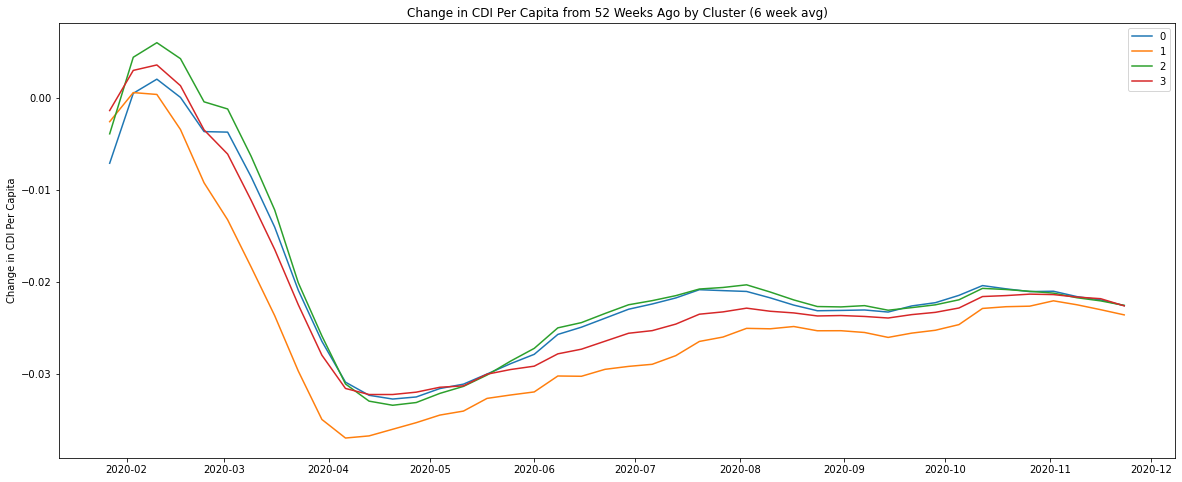

In [72]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_diff_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title(
    'Change in CDI Per Capita from 52 Weeks Ago by Cluster (6 week avg)')
ax.set_ylabel('Change in CDI Per Capita')
ax.legend()
plt.show()

In [73]:
cdi_cbg_df = merge_df.groupby(by=['date_range_start', 'cbg']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_cbg_df = cdi_cbg_df.merge(cbg_df, how='outer', on=['cbg'])
cdi_cbg_df = cdi_cbg_df.sort_values(by=['date_range_start', 'cbg'])
cdi_cbg_df[
    'cdi_per_capita'] = cdi_cbg_df['cdi'] / cdi_cbg_df['population']

In [74]:
cdi_cbg_df

,date_range_start,cbg,cdi,cluster,population,cdi_per_capita
0,2019-01-07 00:00:00-05:00,360050001001,156.826608,2,6864,0.022848
98,2019-01-07 00:00:00-05:00,360050002001,41.926304,2,1744,0.024040
200,2019-01-07 00:00:00-05:00,360050002002,64.292530,2,1569,0.040977
302,2019-01-07 00:00:00-05:00,360050002003,84.304776,3,1219,0.069159
404,2019-01-07 00:00:00-05:00,360050004001,16.703557,3,598,0.027932
...,...,...,...,...,...,...
630216,2020-12-28 00:00:00-05:00,360850319012,15.289446,3,1223,0.012502
630318,2020-12-28 00:00:00-05:00,360850319021,27.782982,2,1731,0.016050
630420,2020-12-28 00:00:00-05:00,360850319022,19.577289,0,1667,0.011744
630522,2020-12-28 00:00:00-05:00,360850319023,22.039937,0,1945,0.011332


In [75]:
cdi_cbg_df = cdi_cbg_df.rename(columns={'home_cbg': 'cbg'})
cdi_cbg_diff_df = create_diff_df(cdi_cbg_df,
                                     diff_columns=['cdi', 'cdi_per_capita'],
                                     keep_columns=['cbg'])
cdi_cbg_diff_2020_df = cdi_cbg_diff_df.groupby(by=['cbg']).agg({'cdi': 'sum'})
cdi_cbg_diff_2020_df.head()

,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
9656,2019-01-07 00:00:00-05:00,360050056001,34.118243,2,956,0.035689,2019,2
9758,2019-01-07 00:00:00-05:00,360050056002,30.050199,2,601,0.050000,2019,2
9860,2019-01-07 00:00:00-05:00,360050056003,28.173190,2,722,0.039021,2019,2
9962,2019-01-07 00:00:00-05:00,360050059021,232.064890,2,866,0.267973,2019,2
10064,2019-01-07 00:00:00-05:00,360050059022,65.762952,2,1885,0.034888,2019,2
10166,2019-01-07 00:00:00-05:00,360050060001,31.719555,2,1386,0.022886,2019,2
10268,2019-01-07 00:00:00-05:00,360050061002,202.364947,0,3720,0.054399,2019,2
10370,2019-01-07 00:00:00-05:00,360050062001,48.494439,2,1092,0.044409,2019,2
10472,2019-01-07 00:00:00-05:00,360050062002,54.905976,2,1446,0.037971,2019,2
10574,2019-01-07 00:00:00-05:00,360050062003,66.198155,2,2608,0.025383,2019,2


,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
0,2019-01-07 00:00:00-05:00,360050001001,156.826608,2,6864,0.022848,2019,2
1,2019-01-07 00:00:00-05:00,360050002001,41.926304,2,1744,0.024040,2019,2
2,2019-01-07 00:00:00-05:00,360050002002,64.292530,2,1569,0.040977,2019,2
3,2019-01-07 00:00:00-05:00,360050002003,84.304776,3,1219,0.069159,2019,2
4,2019-01-07 00:00:00-05:00,360050004001,16.703557,3,598,0.027932,2019,2


,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
0,2020-01-06 00:00:00-05:00,360050001001,209.389274,2,6864,0.030505,2020,2
1,2020-01-06 00:00:00-05:00,360050002001,70.837399,2,1744,0.040618,2020,2
2,2020-01-06 00:00:00-05:00,360050002002,105.865440,2,1569,0.067473,2020,2
3,2020-01-06 00:00:00-05:00,360050002003,79.903352,3,1219,0.065548,2020,2
4,2020-01-06 00:00:00-05:00,360050004001,42.504528,3,598,0.071078,2020,2


,cbg,week,date_range_start,cdi,cdi_per_capita
0,360050001001,2,2020-01-06 00:00:00-05:00,52.562666,0.007658
1,360050002001,2,2020-01-06 00:00:00-05:00,28.911095,0.016577
2,360050002002,2,2020-01-06 00:00:00-05:00,41.572910,0.026496
3,360050002003,2,2020-01-06 00:00:00-05:00,-4.401424,-0.003611
4,360050004001,2,2020-01-06 00:00:00-05:00,25.800972,0.043145


,cdi
cbg,
360050001001,-219.454746
360050002001,-720.171789
360050002002,-897.445506
360050002003,-1938.630037
360050004001,-2144.795385


In [76]:
cdi_cbg_diff_2020_df.to_csv('./exports/cdi/cbg_diff_2020.csv', index=False)

In [77]:
peek(merge_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population
0,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.5,0.5,155.884113,2,6864
1,zzw-225@627-s7t-2ff,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.5,0.5,0.942495,2,6864
2,22b-222@627-s27-fvf,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.2,0.2,3.545440,2,6864


26592552


## Plot CDI by Borough

In [92]:
COUNTY_BRONX = 36005
COUNTY_KINGS = 36047
COUNTY_NEW_YORK = 36061
COUNTY_QUEENS = 36081
COUNTY_RICHMOND = 36085

In [90]:
360050001001 // 10000000

36005

In [34]:
cbg_df
cbg_df['borough'] = ''
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_BRONX), 'borough'] = 'Bronx'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_KINGS), 'borough'] = 'Kings'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_NEW_YORK), 'borough'] = 'Manhattan'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_QUEENS), 'borough'] = 'Queens'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_RICHMOND), 'borough'] = 'Staten Island'
cbg_df

,cbg,cluster,population,borough
0,360050001001,2,6864,Bronx
1,360050002001,2,1744,Bronx
2,360050002002,2,1569,Bronx
3,360050002003,3,1219,Bronx
4,360050004001,3,598,Bronx
...,...,...,...,...
6216,360850319012,3,1223,Staten Island
6217,360850319021,2,1731,Staten Island
6218,360850319022,0,1667,Staten Island
6219,360850319023,0,1945,Staten Island


In [94]:
borough_df = merge_df.copy()
borough_df['borough'] = ''
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_BRONX), 'borough'] = 'Bronx'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_KINGS), 'borough'] = 'Kings'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_NEW_YORK), 'borough'] = 'Manhattan'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_QUEENS), 'borough'] = 'Queens'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_RICHMOND), 'borough'] = 'Staten Island'
borough_df

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population,borough
0,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.5,0.5,155.884113,2,6864,Bronx
1,zzw-225@627-s7t-2ff,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.5,0.5,0.942495,2,6864,Bronx
2,22b-222@627-s27-fvf,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.2,0.2,3.545440,2,6864,Bronx
3,zzy-223@627-sb6-g8v,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.2,0.2,0.000000,2,6864,Bronx
4,225-222@627-s8w-vfz,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.2,0.2,10.950320,2,6864,Bronx
...,...,...,...,...,...,...,...,...,...,...,...
26592547,22b-222@627-s7z-zpv,2019-11-04 00:00:00-05:00,360810050001,4,24.500000,0.5,0.5,2.221154,2,49,Queens
26592548,224-222@627-s82-4qf,2019-11-18 00:00:00-05:00,360810050001,4,24.500000,0.5,0.5,2.152027,2,49,Queens
26592549,22s-222@627-s7z-s3q,2019-11-18 00:00:00-05:00,360810050001,4,24.500000,0.5,0.5,0.819909,2,49,Queens
26592550,zzw-223@627-s82-52k,2020-10-19 00:00:00-04:00,360810050001,4,17.818182,0.5,0.5,0.000000,2,49,Queens


In [95]:
def smoothen_within(df, columns=[], by=None, N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

In [35]:
borough_population_df = cbg_df.groupby(by=['borough']).agg({
    'population': 'sum'
}).reset_index()
borough_population_df

,borough,population
0,Bronx,1435068
1,Kings,2589966
2,Manhattan,1631991
3,Queens,2287377
4,Staten Island,474890


In [40]:
cdi_borough_df = borough_df.groupby(by=['date_range_start', 'borough']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_borough_df = cdi_borough_df.merge(borough_population_df, how='outer', on=['borough'])
cdi_borough_df = cdi_borough_df.sort_values(by=['date_range_start', 'borough'])
cdi_borough_df[
    'cdi_per_capita'] = cdi_borough_df['cdi'] / cdi_borough_df['population']
cdi_borough_df = smoothen_within(cdi_borough_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='borough')
#cdi_borough_df.to_csv('./exports/cdi/total_by_borough.csv', index=None)
cdi_borough_df.head()

,date_range_start,borough,cdi,population,cdi_per_capita
0,2019-01-07 00:00:00-05:00,Bronx,NaN,1435068,NaN
0,2019-01-07 00:00:00-05:00,Kings,NaN,2589966,NaN
0,2019-01-07 00:00:00-05:00,Manhattan,NaN,1631991,NaN
0,2019-01-07 00:00:00-05:00,Queens,NaN,2287377,NaN
0,2019-01-07 00:00:00-05:00,Staten Island,NaN,474890,NaN


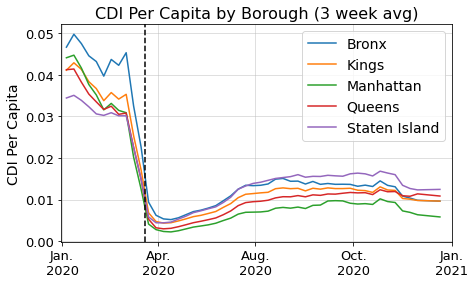

In [41]:
fig, ax = plt.subplots(figsize=(7, 4))
cdi_2020_borough_df = cdi_borough_df[cdi_borough_df['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
for key, group in cdi_2020_borough_df.groupby(by=['borough']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('CDI Per Capita by Borough (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('CDI Per Capita', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

ax.legend(fontsize=FONT_SIZE_LEGEND)
plt.show()

## Plot CDI by POI Category

In [45]:
poi_df = pd.read_csv(f'./exports/poi_health_recategorized.csv')
categories = list(set(poi_df['category']))
peek(poi_df)

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude
0,222-222@627-s94-nwk,360470395002,445210,Specialty Food Stores,Meat Markets,Broadway Meats,3177.0,40.691436,-73.924891
1,223-222@627-rw6-zfz,360050386008,445110,Supermarkets,Supermarkets and Other Grocery (except Conveni...,Foodtown,3401.0,40.876890,-73.847776
2,223-222@627-rwq-vcq,360050117001,445110,Supermarkets,Supermarkets and Other Grocery (except Conveni...,Kirsch Mushroom Company,10079.0,40.816779,-73.883401


36475


In [46]:
cdi_hc_df = merge_df.merge(poi_df[['placekey', 'category']], on=['placekey'], how='inner')
cdi_hc_df = cdi_hc_df[cdi_hc_df['category'].isin(['Supermarkets', 'Delis and Convenience Stores'])]
peek(cdi_hc_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population,category
20526,22b-222@627-s27-fvf,2019-01-14 00:00:00-05:00,360050001001,4,212.837209,0.200000,0.200000,3.545440,2,6864,Delis and Convenience Stores
20527,22b-222@627-s27-fvf,2020-11-30 00:00:00-05:00,360050396004,4,23.535484,0.100000,0.100000,0.273621,2,912,Delis and Convenience Stores
20528,22b-222@627-s27-fvf,2019-01-28 00:00:00-05:00,360810102002,4,7.126731,0.009732,0.009732,0.096458,3,1673,Delis and Convenience Stores


2750463


In [47]:
cdi_hc_df = cdi_hc_df.groupby(by=['date_range_start', 'category']).agg({
    'cdi': 'sum'
}).reset_index()
#cdi_hc_df = cdi_hc_df.merge(category_df, how='outer', on=['category'])
cdi_hc_df = cdi_hc_df.sort_values(by=['date_range_start', 'category'])
cdi_hc_df['cdi_per_capita'] = cdi_hc_df['cdi'] / cbg_df['population'].sum()
cdi_hc_df = smoothen_within(cdi_hc_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='category')
peek(cdi_hc_df)

,date_range_start,category,cdi,cdi_per_capita
0,2019-01-07 00:00:00-05:00,Delis and Convenience Stores,NaN,NaN
0,2019-01-07 00:00:00-05:00,Supermarkets,NaN,NaN
1,2019-01-14 00:00:00-05:00,Delis and Convenience Stores,158538.299373,0.01883


204


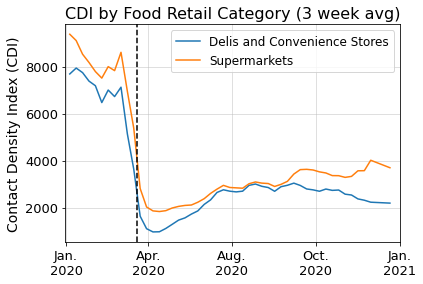

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))
for key, group in cdi_hc_df.groupby(by=['category']):
    group_2020 = group[group['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
    ax.plot(group_2020['date_range_start'], group_2020['cdi'], label=key)
ax.set_title('CDI by Food Retail Category (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('Contact Density Index (CDI)', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.legend(fontsize=FONT_SIZE_LEGEND-2)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

plt.show()